In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from datasets import load_dataset
# from peft import get_peft_model, LoraConfig, TaskType
import flwr as fl
# from opacus import PrivacyEngine
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# from collections import OrderedDict

# my py files
from device import move_to_device, get_device
from data import load_data
from lora import create_lora_model
from clients import FlowerClient
from differential_privacy import differential_privacy
from server import start_fl_server
import logging

import multiprocessing
import time


logging.basicConfig(level=logging.INFO)

/home/student/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-04 02:02:50.500536: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 02:02:51.711520: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO:datasets:PyTorch version 2.4.0+cu118 available.
INFO:datasets:TensorFlow version 2.16.1 available.


In [2]:
# list of  different experimental setup options:

scenarios = [
    {"name": "LoRA Only", "federated": False, "differential_privacy": False},
    {"name": "LoRA + Federated", "federated": True, "differential_privacy": False},
    {"name": "LoRA + Federated + DP", "federated": True, "differential_privacy": True},
]

# # Experiment Scenarios
# scenarios = [
#     {"name": "LoRA Only", "federated": False, "dp_mode": "none", "adaptive": False},
#     {"name": "LoRA + Federated (No DP)", "federated": True, "dp_mode": "none", "adaptive": False},
#     {"name": "Server-Side DP (Fixed)", "federated": True, "dp_mode": "server", "adaptive": False},
#     {"name": "Server-Side DP (Adaptive)", "federated": True, "dp_mode": "server", "adaptive": True},
#     # {"name": "Client-Side DP", "federated": True, "dp_mode": "client", "adaptive": False},
# ]



# List of transformers to test

models_to_test = [
    {"name": "prajjwal1/bert-tiny", "target_modules": ["query", "key", "value"]},
    {"name": "google/mobilebert-uncased", "target_modules": ["query", "key", "value"]},
    {"name": "distilbert-base-uncased", "target_modules": ["q_lin", "v_lin"]},
]

# Hyperparameters
epochs = 5
noise_multiplier = 1.0
clipping_norm = 1.0

results = pd.DataFrame(columns=["Model", "Scenario", "Accuracy", "Loss"])


# Differential Privacy parameters
dp_params = {
    "noise_multiplier": 1.0,
    "max_grad_norm": 1.0,
}

In [3]:
def launch_server():
    start_fl_server()



def launch_client(model, trainloader, testloader, dp_enabled, dp_params):
    # Create Flower client
    client = FlowerClient(
        model=model,
        trainloader=trainloader,
        testloader=testloader,
        device=get_device(),
        dp_enabled=dp_enabled,
        dp_params=dp_params
    )

    # Start Flower client
    fl.client.start_numpy_client(server_address="localhost:8080", client=client)

In [4]:
# Launch server process
server_process = multiprocessing.Process(target=launch_server)
logging.info("Starting FL server...")
server_process.start()

# Allow server to initialize
time.sleep(5)


INFO:root:Starting FL server...
INFO:root:Starting Flower server...
	Instead, use the `flower-superlink` CLI command to start a SuperLink as shown below:

		$ flower-superlink --insecure

	To view usage and all available options, run:

		$ flower-superlink --help

	Using `start_server()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flower-superlink` CLI command to start a SuperLink as shown below:

		$ flower-superlink --insecure

	To view usage and all available options, run:

		$ flower-superlink --help

	Using `start_server()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower server, config: num_rounds=10, round_timeout=180s
INFO:flwr:Starting Flower server, config: num_rounds=10, round_timeout=180s
INFO :      Flower ECE: gRPC server running (10 rounds), SSL i

Prepare a DataFrame to store the results of each experiment:

In [5]:
client_processes = []

for model_name in models_to_test:
    # Initialize tokenizer and data loaders
    tokenizer = AutoTokenizer.from_pretrained(model_name["name"])
    # trainloader = load_data(tokenizer, split="train[:10%]") # 10% for debugging 
    # testloader = load_data(tokenizer, split="test[:10%]")

    trainloader = load_data(tokenizer, split="train") # 100% for final run 
    testloader = load_data(tokenizer, split="test")
    for scenario in scenarios:
        logging.info(f"Running experiment: {scenario['name']} with {model_name['name']}")
        # Initialize model
        model = create_lora_model(
            model_class=AutoModelForSequenceClassification,
            transformer_model=model_name["name"],
            rank=16,
            num_labels=2,
            target_modules=model_name["target_modules"]
        )
         # Federated Learning Scenario
        if scenario["federated"]:
            if scenario["differential_privacy"]:
                # Start FL server
                p = multiprocessing.Process(
                    target=launch_client,
                    args=(model, scenario,trainloader, testloader,scenario["differential_privacy"], dp_params)
                )
                p.start()
                client_processes.append(p)
            else:
                p = multiprocessing.Process(
                    target=launch_client,
                    args=(model, scenario,trainloader, testloader,scenario["differential_privacy"], dp_params)
                )
                p.start()
                client_processes.append(p)

        else:
            # Local training
            optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

            if scenario["differential_privacy"]:
                model, optimizer, trainloader = differential_privacy(model, optimizer, trainloader, **dp_params)
                criterion = torch.nn.CrossEntropyLoss()
                model.train()
                for epoch in range(epochs):  # Adjust epochs as needed
                    logging.info(f"Epoch {epoch + 1}/{epochs}")
                    for batch in trainloader:
                        optimizer.zero_grad()

                        # GPU acceleration 
                        input_ids = move_to_device(batch["input_ids"])
                        attention_mask = move_to_device(batch["attention_mask"])
                        labels = move_to_device(batch["label"])

                        # The acual training
                        outputs = model(input_ids, attention_mask=attention_mask)
                        loss = criterion(outputs.logits, labels)
                        loss.backward()
                        optimizer.step()

        # Evaluation
        criterion = torch.nn.CrossEntropyLoss()
        model.eval()
        total_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for batch in testloader:
                print(f"Processing batch of size: {len(batch['input_ids'])}")
                # print("Batch name:",batch)
                print(batch["input_ids"].shape)
                if len(batch["input_ids"]) == 0:
                    logging.warning("Empty batch detected during evaluation.")
                    continue
                        
                # GPU acceleration 
                input_ids = move_to_device(batch["input_ids"])
                attention_mask = move_to_device(batch["attention_mask"])
                labels = move_to_device(batch["label"])

                # The actual testing/evaluation
                outputs = model(input_ids, attention_mask=attention_mask)
                total_loss += criterion(outputs.logits, labels).item()
                preds = outputs.logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
            
        # Handle zero division
        accuracy = correct / total if total > 0 else 0.0
        loss = total_loss / len(testloader) if len(testloader) > 0 else 0.0
        # Add new rows with .loc
        results.loc[len(results)] = {
            "Model": model_name["name"],
            "Scenario": scenario["name"],
            "Loss": total_loss / (len(testloader) if len(testloader) > 0 else 1),
            "Accuracy": accuracy,
        }

logging.info("Shutting down FL server")
server_process.terminate()

Map: 100%|██████████| 25000/25000 [00:12<00:00, 1997.55 examples/s]
INFO:root:Batch input_ids shape: torch.Size([8, 512])
INFO:root:Batch labels shape: torch.Size([8])
Map: 100%|██████████| 25000/25000 [00:12<00:00, 2061.40 examples/s]
INFO:root:Batch input_ids shape: torch.Size([8, 512])
INFO:root:Batch labels shape: torch.Size([8])
INFO:root:Running experiment: LoRA Only with prajjwal1/bert-tiny
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Running experiment: LoRA + Federated with prajjwal1/bert-tiny


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:root:Using CUDA
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Process Process-2:
Traceback (most recent call last):
INFO:root:Using CUDA
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
INFO:root:Using CUDA
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
INFO:root:Using CUDA
TypeError: launch_client() 

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:root:Using CUDA
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Process Process-3:
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
INFO:root:Using CUDA
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
TypeError: launch_client() takes 5 positional arguments but 6 were gi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


Map: 100%|██████████| 25000/25000 [00:12<00:00, 2002.41 examples/s]
INFO:root:Batch input_ids shape: torch.Size([8, 512])
INFO:root:Batch labels shape: torch.Size([8])
Map: 100%|██████████| 25000/25000 [00:11<00:00, 2101.03 examples/s]
INFO:root:Batch input_ids shape: torch.Size([8, 512])
INFO:root:Batch labels shape: torch.Size([8])
INFO:root:Running experiment: LoRA Only with google/mobilebert-uncased
Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Running experiment: LoRA + Federated with google/mobilebert-uncased


Processing batch of size: 8
torch.Size([8, 512])


Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:root:Using CUDA
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Process Process-4:
Traceback (most recent call last):
INFO:root:Using CUDA
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
INFO:root:Using CUDA
TypeError: launch_client() takes 5 p

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Running experiment: LoRA + Federated + DP with google/mobilebert-uncased


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:root:Using CUDA
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Process Process-5:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
TypeError: launch_client() takes 5 positional arguments but 6 were given
INFO:

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])


Map: 100%|██████████| 25000/25000 [00:10<00:00, 2425.41 examples/s]
INFO:root:Batch input_ids shape: torch.Size([8, 512])
INFO:root:Batch labels shape: torch.Size([8])
Map: 100%|██████████| 25000/25000 [00:10<00:00, 2450.26 examples/s]
INFO:root:Batch input_ids shape: torch.Size([8, 512])
INFO:root:Batch labels shape: torch.Size([8])
INFO:root:Running experiment: LoRA Only with distilbert-base-uncased
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:U

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Running experiment: LoRA + Federated with distilbert-base-uncased


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:root:Using CUDA
Process Process-6:
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
INFO:root:Using CUDA
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
TypeError: 

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Running experiment: LoRA + Federated + DP with distilbert-base-uncased


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:root:Using CUDA
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Process Process-7:
INFO:root:Using CUDA
Traceback (most recent call last):
INFO:root:Using CUDA
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
INFO:root:Using CUDA
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._targe

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA


Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Shutting down FL server


                       Model               Scenario  Accuracy          Loss
0        prajjwal1/bert-tiny              LoRA Only   0.50004  6.975730e-01
1        prajjwal1/bert-tiny       LoRA + Federated   0.45832  7.033900e-01
2        prajjwal1/bert-tiny  LoRA + Federated + DP   0.55116  6.902533e-01
3  google/mobilebert-uncased              LoRA Only   0.50000  8.360115e+06
4  google/mobilebert-uncased       LoRA + Federated   0.50000  1.497289e+07
5  google/mobilebert-uncased  LoRA + Federated + DP   0.50000  8.274317e+06
6    distilbert-base-uncased              LoRA Only   0.50064  6.956313e-01
7    distilbert-base-uncased       LoRA + Federated   0.50000  6.982455e-01
8    distilbert-base-uncased  LoRA + Federated + DP   0.50000  7.032061e-01


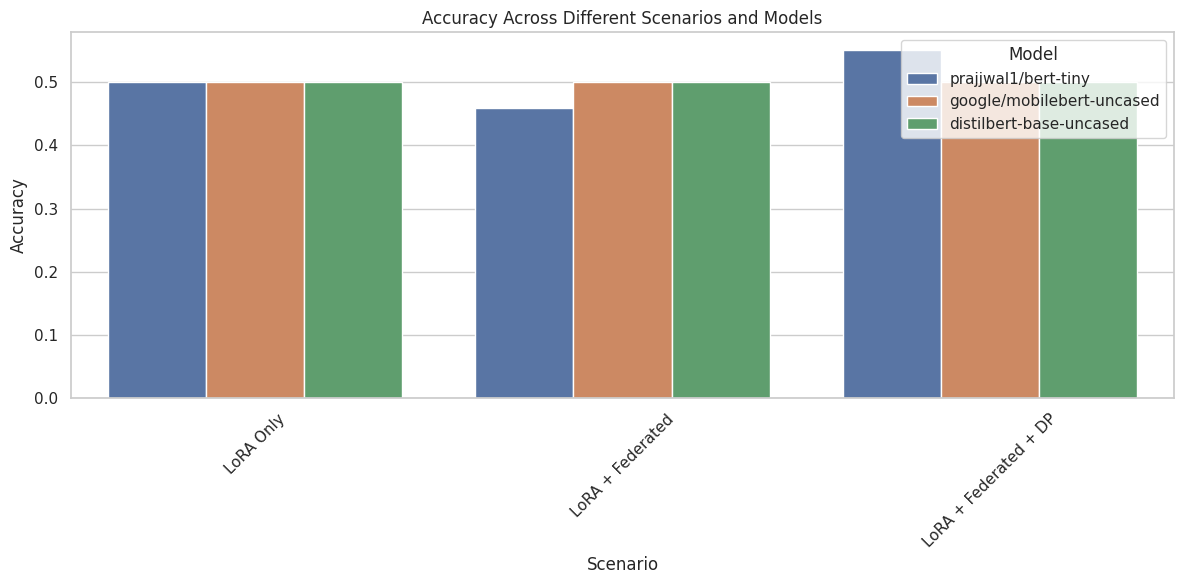

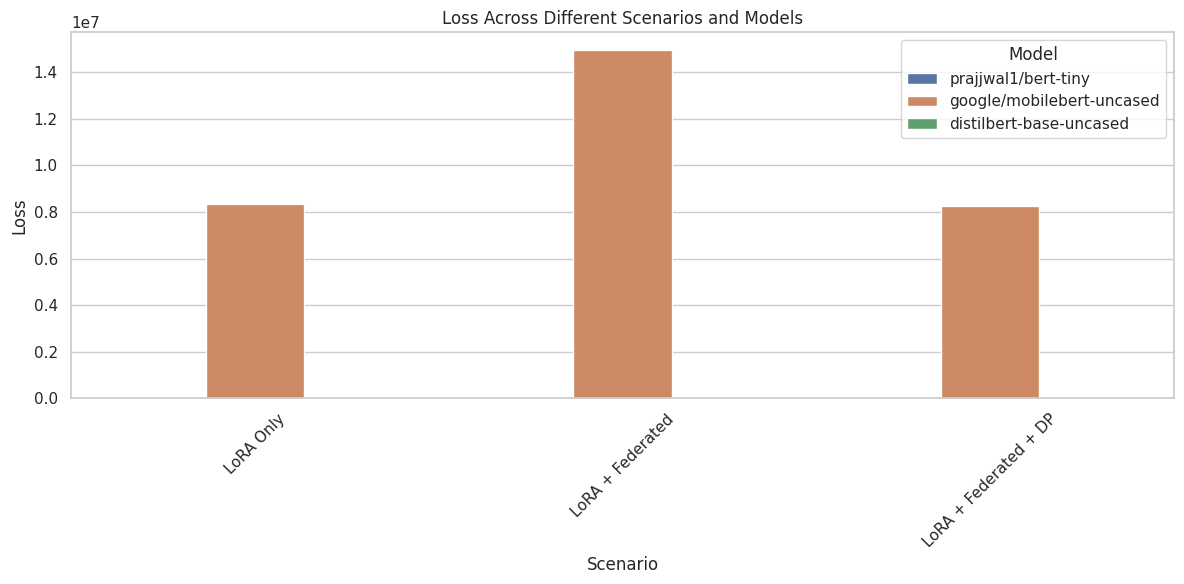

In [6]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Accuracy visualization
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Scenario", y="Accuracy", hue="Model")
plt.title("Accuracy Across Different Scenarios and Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Loss visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Scenario", y="Loss", hue="Model")
plt.title("Loss Across Different Scenarios and Models")
plt.ylabel("Loss")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
plt.show()